In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.text_processing.transformations.synonyms import toy_transformation
from lr.stats.h_testing import DGP, get_matched_results, get_paired_t_statistic
from lr.stats.h_testing import get_boot_sample_under_H0,get_boot_p_value
from lr.stats.h_testing import  LIMts_test
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(train)
pre_process_nli_df(dev)

### Training a model using one version of the modified data

In [3]:
max_features = 500
rho = 0.001
label_translation = get_ternary_label
transformation = entailment_internalization 

dgp = DGP(data=train, transformation=transformation, rho=rho)
train_t = dgp.get_sample()

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}
lr = LRWrapper(hyperparams)
lr.fit(train_t)

### Get t statistic for the observable results and matched results

In [4]:
dev_t = transformation(dev)

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-1.6783627165933783


### Get $S$ bootstrap replications under H0

In [5]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

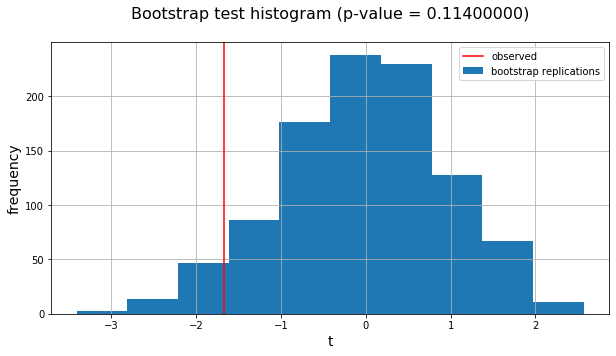

In [6]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

### Performing multiple tests

**test1: entailment internalization**

In [7]:
M,E,S = 5,1,1000


tests1 = LIMts_test(train=train,
                    dev=dev,
                    train_transformation=entailment_internalization,
                    dev_transformation=entailment_internalization,
                    rho=0.78,
                    Model=LRWrapper,
                    hyperparams=hyperparams,
                    M=M,
                    E=E,
                    S=S)

tests1

,m,e,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,test_time,boot_t_1,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,1,0.315,0.560,-8.056095,0.0,0.009335,0.064844,2.448991,0.142864,...,-0.384252,0.730297,0.282899,2.086533,0.000000,1.002509,0.674967,1.070544,-0.525588,1.318478
1,2,1,0.305,0.555,-8.164966,0.0,0.006514,0.058909,2.458179,0.145873,...,-2.002252,-0.687614,-0.428768,1.450953,0.142864,0.782062,2.082630,0.277403,1.210455,0.000000
2,3,1,0.310,0.555,-8.056095,0.0,0.006340,0.064698,2.521910,0.288735,...,0.149079,2.162952,-0.145873,-0.333426,0.590281,0.651635,0.308680,-0.468779,-0.149079,1.581221
3,4,1,0.300,0.550,-8.164966,0.0,0.008367,0.065384,2.994194,-1.046351,...,0.277403,0.149079,-1.265286,-1.291061,-0.701000,-0.715199,0.288735,1.393466,-2.587853,-0.730297
4,5,1,0.295,0.540,-8.056095,0.0,0.007887,0.060554,2.779962,0.590281,...,-1.046351,0.142864,0.156183,-0.544735,1.135009,-0.294948,0.282899,-0.457735,-0.412257,1.002509


### Diferent bootstrap distributions for each experiment

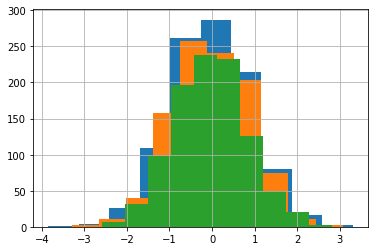

In [8]:
tests1.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

**test2: toy transformation**

In [9]:
tests2 = LIMts_test(train=train,
                   dev=dev,
                   train_transformation=toy_transformation,
                   dev_transformation=toy_transformation,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=M,
                   E=E,
                   S=S)

tests2

,m,e,validation_accuracy,transformed_validation_accuracy,observable_t_stats,p_value,transformation_time,training_time,test_time,boot_t_1,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,1,0.210,0.215,-0.258242,0.834,0.006319,0.050345,2.900291,1.710117,...,1.347719,0.301580,-2.264554,0.785674,1.072113,1.347719,0.944911,0.707992,0.833494,-0.242571
1,2,1,0.215,0.220,-0.301580,0.798,0.004953,0.048887,2.664079,-1.270001,...,0.000000,0.534905,-0.689064,-1.643990,1.421338,0.000000,-1.613977,1.914677,-0.333426,0.000000
2,3,1,0.220,0.220,0.000000,0.936,0.003973,0.045165,2.770225,2.145596,...,-0.707992,0.500313,-0.775761,0.000000,-0.817861,0.258242,0.000000,1.158569,1.002509,1.002509
3,4,1,0.225,0.230,-0.378100,0.734,0.005162,0.056518,2.730058,0.633089,...,1.002509,-1.270001,-0.817861,0.707992,0.378100,-1.137556,1.002509,-0.333426,-1.745189,0.378100
4,5,1,0.210,0.225,-0.906390,0.392,0.003781,0.047217,2.452296,2.535966,...,0.000000,-1.678363,0.000000,0.577832,-0.277403,-1.072113,0.000000,1.217161,-0.277403,0.534905


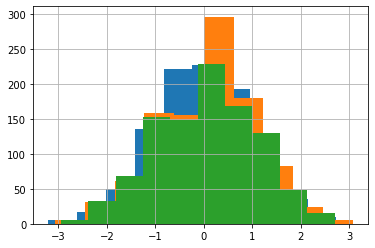

In [10]:
tests2.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

In [11]:
assert np.all(tests1.p_value < (0.05/M*E))
assert not np.all(tests2.p_value < (0.05/M*E))